In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt

In [34]:
def preprocess(df, target_col='target'):
    X = df.drop(target_col, axis=1).copy()
    y = df[[target_col]].copy()
    return X, y


def train(X, y, test_size, random_state=42, model_constructor=LinearRegression, **model_args):
    model = model_constructor(**model_args)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train.values.reshape(-1,))

    return model, X_train, X_test, y_train, y_test


def evaluate(model, X_train, X_test, y_train, y_test, metrics=[f1_score, accuracy_score, precision_score, recall_score]):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    score_train, score_test = {}, {}

    if isinstance(metrics, list):
        for metric in metrics:
            score_train[metric.__name__] = metric(y_train, np.clip(y_pred_train.round(), 0, 1))
            score_test[metric.__name__] = metric(y_test, np.clip(y_pred_test.round(), 0, 1))
    else:
        score_train[metric.__name__] = metric(y_train, y_pred_train.round())
        score_test[metric.__name__] = metric(y_test, y_pred_test.round())


    return score_train, score_test


def optimize(df, test_size, model_constructor, param_list, plot=True, eval_metric='f1_score'):
    X, y = preprocess(df)
    out_data = []

    out_model = None     
    top_test_score = 0   
    
    for params in param_list:
        model, *split_data = train(X, y, test_size=test_size, model_constructor=model_constructor, **params)
        train_score, test_score = evaluate(model, *split_data)
        out_data.append({'params': params, 'train_score': train_score, 'test_score': test_score})

        if test_score[eval_metric] > top_test_score:
            out_model = model
            top_test_score = test_score[eval_metric]
            best_params = params
            best_score = test_score
    
    if plot:
        plt.figure()
        plt.title(eval_metric)
        xlabels = [str(x['params'])+'\n' for x in out_data]
        plt.plot(xlabels, [x['train_score'][eval_metric] for x in out_data])
        plt.plot(xlabels, [x['test_score'][eval_metric] for x in out_data])
        plt.legend(['Train', 'Test'])
        plt.xticks(rotation=90)
        plt.grid('on')
        plt.show()

    return out_model, out_data, best_score, best_params

In [35]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

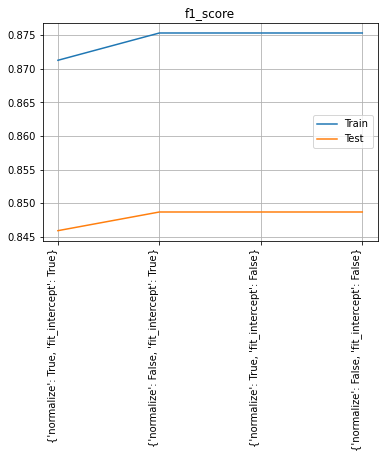

{'f1_score': 0.8486842105263158, 'accuracy_score': 0.8296296296296296, 'precision_score': 0.821656050955414, 'recall_score': 0.8775510204081632}
{'normalize': False, 'fit_intercept': True}


In [36]:
test_size = 0.3
linear_model, linear_res, linear_best_score, linear_best_params = optimize(df, test_size, model_constructor=LinearRegression, param_list=[{'normalize': True, 'fit_intercept': True},
                                                {'normalize': False, 'fit_intercept': True},
                                                {'normalize': True, 'fit_intercept': False},
                                                {'normalize': False, 'fit_intercept': False}])

print(linear_best_score)
print(linear_best_params)

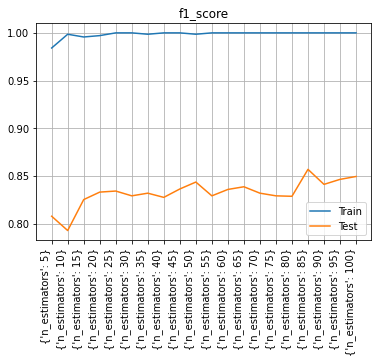

{'f1_score': 0.8571428571428572, 'accuracy_score': 0.8407407407407408, 'precision_score': 0.8376623376623377, 'recall_score': 0.8775510204081632}
{'n_estimators': 85}


In [37]:
rf_model, rf_result, rf_best_score, rf_best_params = optimize(df, test_size, model_constructor=RandomForestClassifier, param_list=[{'n_estimators': x} for x in np.arange(5, 101, 5)])

print(rf_best_score)
print(rf_best_params)

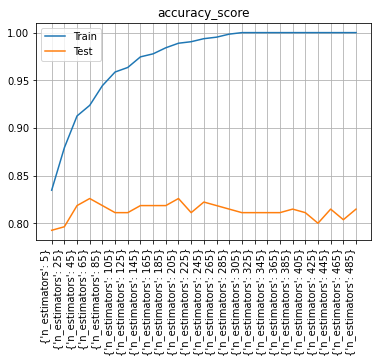

{'f1_score': 0.8459016393442622, 'accuracy_score': 0.825925925925926, 'precision_score': 0.8164556962025317, 'recall_score': 0.8775510204081632} {'n_estimators': 65}


In [38]:
gb_model, gb_result, gb_best_score, gb_best_params = optimize(df, test_size, model_constructor=GradientBoostingClassifier, param_list=[{'n_estimators': x} for x in np.arange(5, 500, 20)], eval_metric='accuracy_score')
print(gb_best_score, gb_best_params)


Text(0.5, 1.0, 'Model Scores Comparison (test only)')

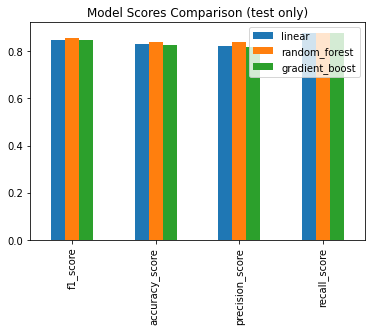

In [39]:
pd.DataFrame([linear_best_score, rf_best_score, gb_best_score], index=['linear', 'random_forest', 'gradient_boost']).T.plot.bar()
plt.title('Model Scores Comparison (test only)')

In [40]:
imp_df = pd.DataFrame(index=df.drop('target', axis=1).columns, data=zip(rf_model.feature_importances_, gb_model.feature_importances_, linear_model.coef_.reshape(-1)), columns=['rf_importance', 'gb_importance', 'linear_coef'])

In [41]:
imp_df.sort_values('rf_importance', ascending=False)

,rf_importance,gb_importance,linear_coef
cp_type_no_pain,0.092269,0.291964,0.204799
heart_rate_peak,0.065410,0.026841,-0.001330
st_dep,0.054890,0.064447,0.093018
age,0.050442,0.058768,0.002220
chol,0.048623,0.069874,-0.000036
vessels_colored,0.047170,0.084535,0.139331
ex_duration,0.037610,0.027218,0.007508
heart_rate_rest,0.036740,0.021632,0.000131
ex_angina,0.035853,0.030669,0.100577
met,0.032537,0.050842,-0.000951
